In [161]:
#pip install gdown
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error

In [3]:
import gdown
import pandas as pd

# 파일 ID와 저장할 파일명 (확장자 포함)
file_ids = ['140hcb09ePTATbJmTgnqeBz602le30Z5z', '13V3gr1MjGhogpZEcECFy9CDktQFTpfcu']
file_names = ['log.csv', 'game_result.csv']

log = None
game_result = None

# 각 파일 다운로드 및 DataFrame으로 불러오기
for fid, fname in zip(file_ids, file_names):
    url = f'https://drive.google.com/uc?id={fid}'
    print(f"Downloading {fname} ...")
    gdown.download(url, fname, quiet=False)
    
    try:
        df = pd.read_csv(fname)
        # 파일 이름에 따라 DataFrame 저장
        if fname == 'log.csv':
            log = df
        elif fname == 'game_result.csv':
            game_result = df
    except Exception as e:
        print(f"파일 {fname} 읽기에 실패하였습니다. 에러: {e}")


Downloading...
From: https://drive.google.com/uc?id=140hcb09ePTATbJmTgnqeBz602le30Z5z
To: C:\Users\82108\Notebook\log.csv
100%|█████████████████████████████████████████████████████████████████████████████| 47.7M/47.7M [00:02<00:00, 23.7MB/s]


Downloading...
From: https://drive.google.com/uc?id=13V3gr1MjGhogpZEcECFy9CDktQFTpfcu
To: C:\Users\82108\Notebook\game_result.csv
100%|███████████████████████████████████████████████████████████████████████████████| 166k/166k [00:00<00:00, 1.37MB/s]


In [4]:
log.head()

,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue


In [5]:
game_result.head()

,gameId,win,TEAM
0,JP1_340505476,False,blue
1,JP1_340505476,True,red
2,JP1_340611094,True,red
3,JP1_340611094,False,blue
4,JP1_340621330,True,red


✅ 1) 인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값

In [6]:
log['each_variable'] = log.groupby(['gameId', 'variable','POSITION','TEAM'])['value'].diff().combine_first(log['value'])

✅ 2) 전처리 </br>
    * 팀/포지션별_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다. </br>
    * 팀/포지션별_totalGold : each_variable의 다섯 구간 평균값을 추가한다. </br>
    * 팀/포지션별_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다. </br>
    * 팀/포지션별_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.</br>
    * 팀/포지션별_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.</br>
    * 팀/포지션별_WARD_KILL : each_variable의 max값을 추가 </br>
    * result : blue팀의 승리여부, 승리 : 1 , 패배 : 0

In [7]:
# result 
blue = game_result[game_result['TEAM'] == 'blue'].reset_index(drop = True)
blue['result'] =  blue.apply(lambda x : 1 if x['win'] == True else 0, axis = 1)
result = blue.drop(columns = ['win','TEAM']).set_index('gameId')
result

,result
gameId,
JP1_340505476,0
JP1_340611094,0
JP1_340621330,0
JP1_340652067,0
JP1_341114767,1
...,...
NA1_4298502759,0
NA1_4298524350,0
NA1_4298572181,0


In [8]:
# target 설정 
log['target'] = log['TEAM'] +'_' + log['POSITION'] + '_' + log['variable']

In [9]:
# minionsKilled : 25분의 minionsKilled value컬럼 값을 추가 
minion = log[(log['variable'] == 'minionsKilled') & (log['time'] == 25)]
minion_df = minion.pivot_table(index = 'gameId' , values = 'value', columns = ['target'])
minion_df.head(1)

target,blue_B_minionsKilled,blue_J_minionsKilled,blue_M_minionsKilled,blue_S_minionsKilled,blue_T_minionsKilled,red_B_minionsKilled,red_J_minionsKilled,red_M_minionsKilled,red_S_minionsKilled,red_T_minionsKilled
gameId,,,,,,,,,,
JP1_340505476,54.0,14.0,140.0,168.0,188.0,168.0,22.0,167.0,52.0,173.0


In [10]:
# 팀/포지션별_totalGold : each_variable의 다섯 구간 평균값을 추가 

# total_Gold 추출 
gold = log[log['variable'] == 'totalGold']
gold = gold.groupby(['target','gameId'])['each_variable'].mean().reset_index()
gold_df = gold.pivot_table(index = 'gameId' , values = 'each_variable' , columns = 'target')

In [11]:
# totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
totalDamageTaken = log[log['variable'] == 'totalDamageTaken'].groupby(['target', 'gameId'])['each_variable'].mean().reset_index()
totalDamageTaken_df = totalDamageTaken.pivot_table(index = 'gameId', values = 'each_variable', columns = 'target')


In [12]:
#* 팀/포지션별_totalDamageDone : each_variable의 다섯 구간 분산값을 추가
totalDamageDone = log[log['variable'] == 'totalDamageDone']
totalDamageDone = totalDamageDone.groupby(['target','gameId'])['each_variable'].var().reset_index()
totalDamageDone_df = totalDamageDone.pivot_table(index = 'gameId', values = 'each_variable', columns = 'target')


In [13]:
# 팀/포지션별_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
ward =  log[(log['variable'] == 'WARD_PLACED') & (log['time'] == 15)].reset_index()
ward_df = ward.pivot_table(index = 'gameId' , values = 'value', columns = 'target')

In [14]:
# 팀/포지션별_WARD_KILL : each_variable의 max값
ward_kill = log[log['variable'] == 'WARD_KILL']
ward_kill = ward_kill.groupby(['gameId','target'])['each_variable'].max().reset_index()
ward_kill_df = ward_kill.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')


In [15]:
# 최종 concat 
final_df= pd.concat([minion_df , gold_df , totalDamageTaken_df , totalDamageDone_df ,ward_df ,ward_kill_df, result], axis =1).reset_index()
final_df.head(4)

,gameId,blue_B_minionsKilled,blue_J_minionsKilled,blue_M_minionsKilled,blue_S_minionsKilled,blue_T_minionsKilled,red_B_minionsKilled,red_J_minionsKilled,red_M_minionsKilled,red_S_minionsKilled,...,blue_J_WARD_KILL,blue_M_WARD_KILL,blue_S_WARD_KILL,blue_T_WARD_KILL,red_B_WARD_KILL,red_J_WARD_KILL,red_M_WARD_KILL,red_S_WARD_KILL,red_T_WARD_KILL,result
0,JP1_340505476,54.0,14.0,140.0,168.0,188.0,168.0,22.0,167.0,52.0,...,1.0,2.0,4.0,4.0,1.0,1.0,1.0,8.0,2.0,0
1,JP1_340611094,181.0,28.0,197.0,26.0,169.0,194.0,48.0,148.0,17.0,...,4.0,2.0,2.0,2.0,2.0,6.0,2.0,5.0,1.0,0
2,JP1_340621330,192.0,61.0,202.0,37.0,97.0,189.0,15.0,147.0,24.0,...,2.0,2.0,6.0,0.0,0.0,4.0,0.0,2.0,1.0,0
3,JP1_340652067,203.0,68.0,166.0,36.0,191.0,217.0,22.0,177.0,34.0,...,4.0,0.0,4.0,5.0,3.0,2.0,2.0,3.0,2.0,0


 ##### ✅ 3) 모델링 
    1) 랜덤포레스트와 그래디언트 부스팅으로 학습
    2) 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터
    3) 학습데이터는 70%를 사용한다
    4) auc값으로 평가를 진행하며 ROC Curve

In [16]:
X = final_df.drop(columns = ['gameId', 'result'],axis = 1)
y = final_df['result']

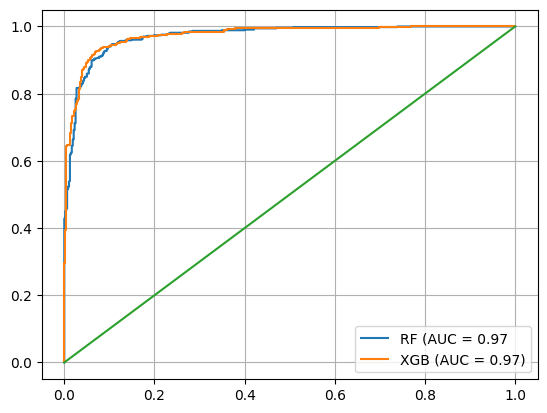

In [17]:

def eval_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

    if name == 'RF' : 

        param = {
            'n_estimators' : [1,10,100] , 
            'min_samples_split' : [1,2,3,4] , 
            'min_samples_leaf' :[1, 2]
        }

        rf_grid = GridSearchCV(estimator=model, param_grid=param, cv = 5, scoring = 'accuracy')
        rf_grid.fit(x_train, y_train)

        # best_grid 
        best_model= rf_grid.best_estimator_

        # Predict 
        rf_pred = best_model.predict(x_test)
        score = accuracy_score(y_test, rf_pred)
        
        # ROC_Curve - predict_proba -- predict_proba(x_test)[:,1] #comma 뺴먹지 말기 
        rf_pred_prob = best_model.predict_proba(x_test)[:,1]
        auc = roc_auc_score(y_test, rf_pred_prob)

        fpr, tpr , _=roc_curve(y_test, rf_pred_prob)
        plt.plot(fpr, tpr, label =f'{name} (AUC = {auc:.2f}')

    elif name =='XGB' : 
        param = {
            'n_estimators': [50, 100, 200],            
            'max_depth': [3, 5, 7],                     
            'learning_rate': [0.01, 0.1, 0.2]
        }

        xgb_grid = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='roc_auc')
        xgb_grid.fit(x_train, y_train)
        best_model = xgb_grid.best_estimator_
        xgb_pred = best_model.predict(x_test)
        score = accuracy_score(y_test, xgb_pred)
        
        xgb_pred_prob = best_model.predict_proba(x_test)[:, 1]
        auc = roc_auc_score(y_test, xgb_pred_prob)
        fpr, tpr, _ = roc_curve(y_test, xgb_pred_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    return score, best_model

lst = []
mlst = []
for name, model in [['RF' , RandomForestClassifier()] , ['XGB', xgb.XGBClassifier()]] : 
    score , best_model= eval_model(name, model)
    lst.append([name, score])
    mlst.append([name, best_model])

plt.plot([0,1], [0,1])
plt.grid(True)
plt.legend()
plt.show()

In [18]:
## 최종 결과 
pd.DataFrame(lst, columns = ['Model','Accuracy_Score'])

,Model,Accuracy_Score
0,RF,0.914116
1,XGB,0.924975


#### ✅ 4. Feature Importance

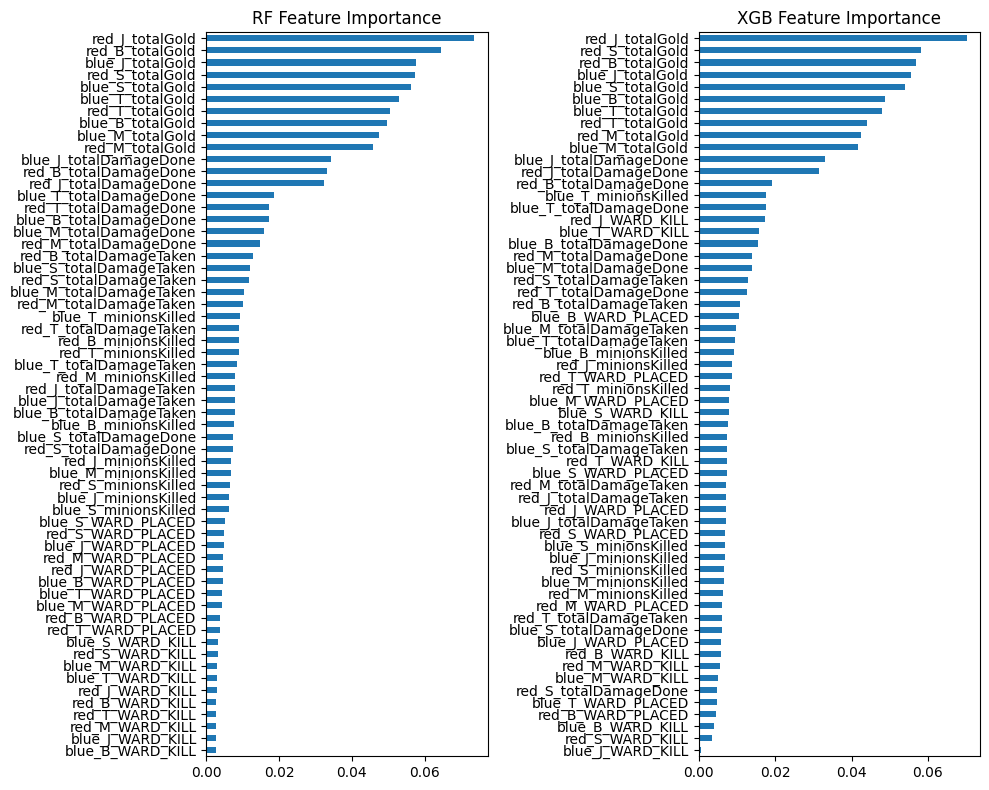

In [19]:
fig, axes = plt.subplots(1,2, figsize = (10, 8))

for axes, (name, model) in zip(axes, mlst) : 
    impo = model.feature_importances_  
    feature = model.feature_names_in_
    imp = pd.Series(impo, index = feature).sort_values()

    imp.plot.barh(ax = axes)
    axes.set_title(f'{name} Feature Importance')
    
plt.tight_layout()
plt.show()

#### ✅ 2.1
    1) 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라.
    2) 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거

In [32]:
df = pd.read_csv('C:/Users/82108/Notebook/PRC_3_data/mc.csv')
df.head() 

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


In [35]:
# 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라.
df = df.groupby(['측정일시']).max().reset_index()

In [50]:
# 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거
df['sum']= df.iloc[:, 2:].sum(axis = 1)

filter_df = df[df['sum'] != 0]
filter_df

,측정일시,측정장소,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지,sum
0,2022-01-10 09:00:00,53,16.67,81.90,1.0,0.12,14.5,17.0,5849.5,0,1023.2,985.0,31955.56
1,2022-01-10 09:05:00,53,16.78,81.65,1.0,0.12,14.0,17.0,6236.0,0,1023.2,985.0,33499.00
2,2022-01-10 09:10:00,53,16.86,81.85,1.0,0.11,14.0,15.0,6045.8,0,1023.1,985.0,32730.88
3,2022-01-10 09:15:00,53,17.01,81.50,1.0,0.10,13.0,13.4,5617.0,0,1023.2,985.0,31004.84
4,2022-01-10 09:20:00,53,17.17,81.10,1.0,0.10,18.0,17.0,5261.0,0,1023.2,985.0,29614.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40784,2022-05-31 23:40:00,53,25.61,51.47,1.0,0.21,16.8,11.0,76.1,0,1007.2,28.0,4869.56
40785,2022-05-31 23:45:00,53,25.64,50.56,1.0,0.28,19.1,7.4,75.5,0,1007.1,28.0,4858.32
40786,2022-05-31 23:50:00,53,25.67,50.33,1.0,0.26,10.0,10.0,103.2,0,1007.1,28.0,4942.24
40787,2022-05-31 23:55:00,53,25.72,50.44,1.0,0.26,11.0,10.5,76.0,0,1007.1,18.0,4800.08


##### ✅ 2.2 데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라. 각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가

In [64]:
filter_df['측정일시'] = pd.to_datetime(filter_df['측정일시'])

def change_time(x) : 
    time = x['측정일시']
    hour = time.hour

    if hour in range(0, 6) :
        return '0'
    elif hour in range(6, 12) : 
        return '1'
    elif hour in range(12, 18) : 
        return '2'
    else : 
        return '3'

filter_df['hour_6']= filter_df.apply(change_time, axis = 1)

filter_df.groupby('hour_6').mean().T

hour_6,0,1,2,3
측정일시,2022-03-22 06:13:45.193798400,2022-03-22 04:08:18.796259584,2022-03-22 06:34:05.100950016,2022-03-22 11:45:17.770550016
측정장소,53.0,53.0,53.0,53.0
온도,19.126401,20.663905,22.305817,19.865287
습도,69.820901,61.973266,51.730485,64.029254
풍향,0.919857,0.920474,0.921526,0.918815
풍속,0.179624,0.234525,0.399507,0.251769
황화수소,14.147446,12.29799,11.160184,13.99931
암모니아,22.089773,30.679407,53.691182,40.41647
휘발성유기화합물,1095.190737,881.189087,313.207611,529.772975
강수량,0.0,0.0,0.0,0.0


##### ✅ 2.3 전처리한 데이터의 변수간 상관관계를 확인
##### ✅ 2.4 hour_6 의 값이 2과 3인 데이터만 필터하고 각 온도~초미세먼지의 컬럼이 date_split 값에 따른 차이가 존재하는지 통계검정

In [72]:
f_df = filter_df.copy()
cor_df = f_df.drop(columns = ['측정장소','측정일시','hour_6','강수량'], axis = 1)
cor_df.corr(method = 'spearman')

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지,sum
온도,1.000000,0.215858,0.322877,0.339797,-0.151304,0.335138,-0.130011,-0.358907,0.229556,0.225593
습도,0.215858,1.000000,0.276171,-0.101411,0.237941,0.581576,0.347012,-0.070733,0.372446,0.581078
풍향,0.322877,0.276171,1.000000,0.457438,0.452365,0.434567,0.443272,0.455852,0.456652,0.459822
풍속,0.339797,-0.101411,0.457438,1.000000,0.109181,0.138343,0.143061,0.123885,0.080995,0.127257
황화수소,-0.151304,0.237941,0.452365,0.109181,1.000000,0.278394,0.383300,0.466901,0.208884,0.278358
암모니아,0.335138,0.581576,0.434567,0.138343,0.278394,1.000000,0.193225,0.001860,0.291688,0.510519
휘발성유기화합물,-0.130011,0.347012,0.443272,0.143061,0.383300,0.193225,1.000000,0.472897,0.358699,0.663140
기압,-0.358907,-0.070733,0.455852,0.123885,0.466901,0.001860,0.472897,1.000000,0.250857,0.149437
초미세먼지,0.229556,0.372446,0.456652,0.080995,0.208884,0.291688,0.358699,0.250857,1.000000,0.719210
sum,0.225593,0.581078,0.459822,0.127257,0.278358,0.510519,0.663140,0.149437,0.719210,1.000000


In [108]:
# 2) hour_6 2,3 
from scipy.stats import ttest_ind

stat = f_df[f_df['hour_6'].isin(['2','3'])].drop(columns = ['측정일시','sum', '측정장소','강수량']).reset_index(drop = True)

res = []
cols = stat.columns[:-1]
for col in cols:
    target = stat[['hour_6', col]]
    g1 = target[target['hour_6'] == '2'][col]
    g2 = target[target['hour_6'] == '3'][col]

    t_stat, p_val = ttest_ind(g1, g2, nan_policy='omit') 
    res.append([col, p_val])

res = pd.DataFrame(res, columns = ['Cols','P_val'])
res['check'] = res['P_val'].apply(lambda x : '유의' if x <= 0.05 else '유의하지 않음')
print(res)

       Cols          P_val    check
0        온도   0.000000e+00       유의
1        습도   0.000000e+00       유의
2        풍향   4.762746e-01  유의하지 않음
3        풍속   0.000000e+00       유의
4      황화수소  4.583729e-259       유의
5      암모니아   4.670395e-14       유의
6  휘발성유기화합물   9.801884e-33       유의
7        기압   5.422660e-01  유의하지 않음
8     초미세먼지   1.165229e-02       유의


##### ✅ 2.5 초미세먼지를 예측하는 모델 / 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가 (RMSE)

In [115]:
model_df= f_df.drop(columns = ['측정장소','측정일시','hour_6','강수량'], axis = 1)

X = model_df.drop(columns = ['초미세먼지'], axis = 1)
y = model_df['초미세먼지']

# 스케일링 
ss = StandardScaler()
s_X = pd.DataFrame(ss.fit_transform(X) , columns = X.columns)

In [118]:

def eval_model (name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(s_X, y, test_size = 0.3 , random_state = 42)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    mse = np.sqrt(mean_squared_error(y_test, pred))

    return mse 


lst = []
for name, model in [['LR', LinearRegression()] , 
                    ['RF' , RandomForestRegressor()]] : 
    mse = eval_model(name, model)
    lst.append([name, mse])

pd.DataFrame(lst, columns = ['Model', 'MSE'])

,Model,MSE
0,LR,2.189179e-12
1,RF,3.160062e+01


### 통계 
✅ 1번 : 어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다. </br>
         최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률

In [122]:
from scipy.stats import expon 

lamb = 10 
t = 7 #향후 7년 

rv = expon(scale = lamb)

# P(X > 7) = 1 - P(X <= 7)
print(1- rv.cdf(t)) 

0.49658530379140964


In [123]:
# 지난 지진 발생 후 15년이 지났다. 8년 이내에 지진이 발생할 확률은? 
# 지수 분포의 메모리리스 특성 때문에, 15년의 특성이 반영되지 않는다. 즉 8년 이내의 값을 구한다. 

print(rv.cdf(8))

0.5506710358827784


✅ 2 번 </br>
    1. 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인 </br>
    2. 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정

In [124]:
df = pd.read_csv('C:/Users/82108/Notebook/PRC_3_data/s1.csv')
df.head() 

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030
4,ID-5,저탄고단,저강도,4.765847


In [139]:
import scipy.stats as stats

df['gr'] = df['식단'] + df['운동']

shapi = []
for group in df['gr'].unique() : 
    target = df[df['gr'] == group]['감량체중']
    stat, pval = stats.shapiro(target)
    shapi.append([group, pval])

s = pd.DataFrame(shapi , columns = ['Group', 'P_value']) 
s['check'] = s.apply(lambda x : '귀무가설 기각' if x['P_value'] <= 0.05 else '귀무가설 채택', axis = 1)
print(s)
print('''
귀무가설 : 정규성을 가진다
대립가설 : 정규성이 아니다. 
''')

     Group   P_value    check
0  저탄고단저강도  0.660390  귀무가설 채택
1  저탄고단고강도  0.370877  귀무가설 채택
2  저탄고지저강도  0.326866  귀무가설 채택
3  저탄고지고강도  0.162404  귀무가설 채택

귀무가설 : 정규성을 가진다
대립가설 : 정규성이 아니다. 





In [141]:
## CHECK- 암기 필수 

levene = []

for group in df['gr'].unique() : 
    target = df[df['gr'] == group]['감량체중'].values
    not_target = df[df['gr'] != group]['감량체중'].values
    
    stat, pval = stats.levene(target, not_target)
    levene.append([group, pval])

levene = pd.DataFrame(levene , columns = ['Group', 'P_value']) 
levene['check'] = levene.apply(lambda x : '귀무가설 기각' if x['P_value'] <= 0.05 else '귀무가설 채택', axis = 1)
print(s)
print('''
귀무가설 : 등분산이다. 
대립가설 : 등분산이 아니다. 
''')

     Group   P_value    check
0  저탄고단저강도  0.660390  귀무가설 채택
1  저탄고단고강도  0.370877  귀무가설 채택
2  저탄고지저강도  0.326866  귀무가설 채택
3  저탄고지고강도  0.162404  귀무가설 채택

귀무가설 : 등분산이다. 
대립가설 : 등분산이 아니다. 



In [142]:
print('''
1) 주효과 
    귀무 : 식단과 운동에 상관없이 감량 체중은 같다.
    대립 : 적어도 하나는 식단과 운동에 따라 체중이 다르다. 

2) 교호 작용 
    귀무 : 식단과 운동은 교호작용이 없다.
    대립 : 식단과 운동은 교호작용이 있다. 
''')


1) 주효과 
    귀무 : 식단과 운동에 상관없이 감량 체중은 같다.
    대립 : 적어도 하나는 식단과 운동에 따라 체중이 다르다. 

2) 교호 작용 
    귀무 : 식단과 운동은 교호작용이 없다.
    대립 : 식단과 운동은 교호작용이 있다. 



,df,sum_sq,mean_sq,F,PR(>F)
C(식단),1.0,16.257434,16.257434,18.352972,3.198226e-05
C(운동),1.0,70.040700,70.040700,79.068753,1.401288e-15
C(식단):C(운동),1.0,0.714673,0.714673,0.806792,3.704546e-01
Residual,156.0,138.187955,0.885820,NaN,NaN


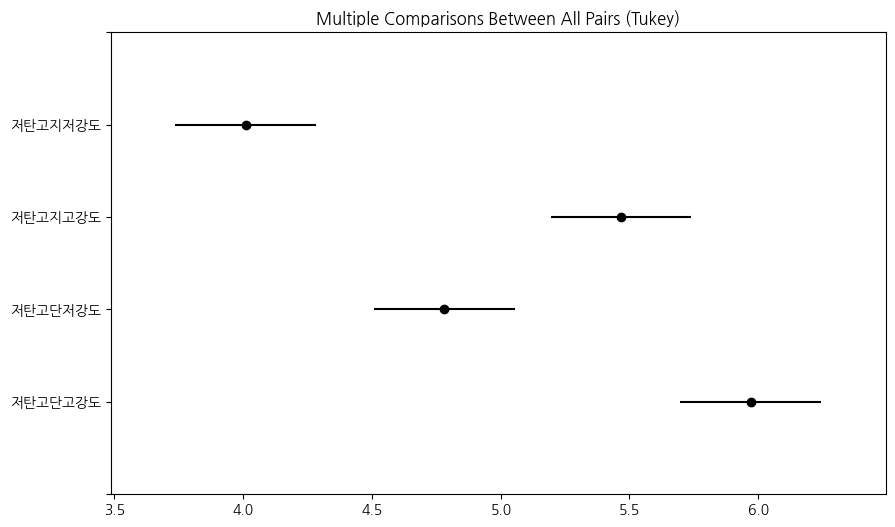

In [159]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd 

model = ols('감량체중 ~ C(식단) * C(운동)' , data = df).fit()
res = sm.stats.anova_lm(model)
display(res)

tukey = pairwise_tukeyhsd(df['감량체중'] , df['식단'] + df['운동'], alpha = 0.05)
tukey.plot_simultaneous()
plt.show()

✅ 3 번 </br>
   * 1. 나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델 </br> 
   * 2. test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출 </br> 
   * 3. 새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값 </br> 
   * 4. 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인 </br> 

In [172]:
df = pd.read_csv('C:/Users/82108/Notebook/PRC_3_data/s3.csv')
df.head() 
df['Gender'] = df['Gender'].astype(str)

In [184]:
# 0,2,3,4 의 인덱스 : 테스트 데이터 / 나머지 학습 데이터
y = df['Purchased']

dummi_X = pd.get_dummies(df['Gender'] , dtype =int)

nums = df[['Age','EstimatedSalary']]
scaled_X = pd.DataFrame(StandardScaler().fit_transform(nums) , columns = nums.columns)

X = pd.concat([dummi_X , scaled_X], axis = 1)

# 데이터 세트 구정
x_train = X[~ X.index.isin([0,2,3,4])]
x_test = X[X.index.isin([0,2,3,4])] 

y_train =  y[~ y.index.isin([0,2,3,4])]
y_test =  y[y.index.isin([0,2,3,4])] 

In [188]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

lr.predict_proba(x_test)[3]

array([0.40780504, 0.59219496])

In [194]:
# 변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과
x = np.array([0, 1 , -0.6 , -1.8])

# np.dot(x, lr.coef_.T)	특성과 계수의 선형 결합 + 회귀모델의 절편
# np.dot(x, lr.coef_.T)  # → 1.5*0.3 + 2.0*0.5 = 0.45 + 1.0 = 1.45
z = np.dot(x, lr.coef_.T) + lr.intercept_

print(1 / (1 + np.exp(-z)))

[0.42247379]


In [198]:
# 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐
np.exp(lr.coef_[0])

array([1.19079864, 0.83979769, 2.11251301, 1.96466028])